In [36]:
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from iminuit import Minuit
import math

# Part1: Create exponential random numbers for a given value of tau and plot it ; Exponential pdf = 1/τ*e^(-t/τ)

In [ ]:
tauArr = []
llArr = []


##transforming U(0,1) to exponential random number t
def generate_time(n1,tau):
    ran = ROOT.TRandom3(0)
    root_time_measurements = []
    for _ in range(n1):
        r1 = ran.Uniform(0.0, 1.0)
        r = -np.log(r1)/(1/tau)
        root_time_measurements.append(r)
    return root_time_measurements

# generating exponential random number t using numpy

In [38]:
def generate_time_numpy(n1,tau):
    numpy_time_measurements = np.random.exponential(scale=tau, size=n1)
    return numpy_time_measurements

In [39]:
##filling tree with the time measuremnets
def fill_tree_with_time(outfile, time_measurements):
    tree = ROOT.TTree("time_measurements", "Time Measurement Data")
    x = np.zeros(1, dtype=float)
    tree.Branch("x", x, "x/D")

    for r in time_measurements:
        x[0] = r
        tree.Fill()

    tree.Write()

In [40]:
##plot the time measurements
def plot_time_measurements(outfile):
    tree = outfile.Get("time_measurements")
    x_data = np.array([entry.x for entry in tree])
    plt.figure(figsize=(8, 6))
    plt.hist(x_data, bins=50, density=True, alpha=0.7, label="Generated Time Measurement Data")
    plt.xlabel("time")
    plt.ylabel("")
    plt.legend()
    plt.title("Generated Exponential Distribution")
    plt.show()
    plt.close('all')

In [41]:
### open the rootfile and fill a tree that will be used again
outfile = ROOT.TFile("DecayTimeMeasurements.root", "recreate")
n1 = 1000 #number of time measurements in a particular experiment
tau = 5 #mean muon lifetime
time_measurements = generate_time(n1,tau) 
#time_measurements = generate_time_numpy(n1,tau) #generating exponential random number t using numpy
fill_tree_with_time(outfile, time_measurements) 

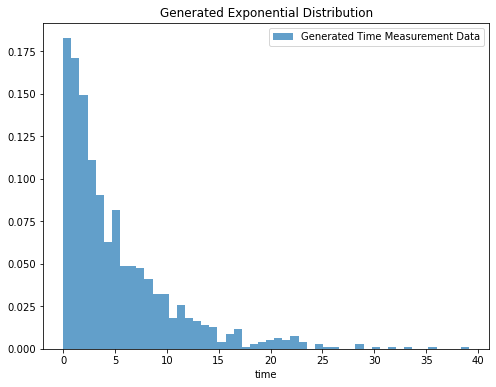

In [42]:
plot_time_measurements(outfile)

# Unbinned NLL fit to the generated time_measurements data using Minuit

In [43]:

def fit_time_measurements(outfile):
    tree = outfile.Get("time_measurements")

    def fcn(tau):
        time = [entry.x for entry in tree]
        lnL = 0.0
        for x in time:
            pdf = (np.exp(-x/tau))/tau
            if pdf > 0.0:
                lnL += np.log(pdf)
            else:
                print("pdf is negative!!!")
        f = -2.0 * lnL
        tauArr.append(tau)
        llArr.append(f)
        return f
    minuit = Minuit(fcn, tau=2)
    minuit.limits["tau"] = (2, 10)
    minuit.migrad()
    minuit.hesse()
    tau_expected = minuit.values["tau"]
    error_tau_expected = minuit.errors["tau"]
    print("Expected tau:", tau_expected, "+/-", error_tau_expected)
    return tau_expected

# binned NLL fit to the data using Minuit

In [44]:
def binned_fit_time_measurements(bin_counts, bin_edges):
    
### Write a normalized pdf. Then the prob. of finding an event in 
### ith bin = Integral_lowEd^HighEd( 1/tau * exp(-t/tau) dt)
### considering the bins to be narrow enough, we can estimate this at the bin center and multiply by dt

    def fcn(tau):
        
        ntot = np.sum(bin_counts)
        #print(f"Total number of events in the hist {ntot}")
        
        # Calculate the number of bins
        num_bins = len(bin_edges) - 1
        
        lnL = 0
        for i in range(len(bin_counts)):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]
            bin_mid = (bin_start+bin_end)/2.
            bin_width = (bin_end - bin_start)
            count = bin_counts[i]
            #print(f"Counts in {i}^th bin are {count}")
            ### expected counts in ith bin 
            bincount_exp = ntot * (np.exp(-bin_mid/tau))/tau
            #print(f"Expected Counts in {i}^th bin are {bincount_exp}")
            ### poissonian entries
            if bincount_exp > 0.0:
                lnL += -bincount_exp + count * math.log(bincount_exp) - math.log(math.factorial(count))
            else:
                print("pdf is negative!!!")   
        f = -2.0 * lnL
        
        return f
    minuit = Minuit(fcn, tau=2)
    minuit.limits["tau"] = (2, 10)
    minuit.migrad()
    minuit.hesse()
    tau_expected = minuit.values["tau"]
    error_tau_expected = minuit.errors["tau"]
    print("Expected tau:", tau_expected, "+/-", error_tau_expected)
    return tau_expected

# Extended binned NLL fit to the generated time_measurements data using Minuit

In [45]:

def extended_binned_fit_time_measurements(bin_counts, bin_edges):
    
### Write a normalized pdf. Then the prob. of finding an event in 
### ith bin = Integral_lowEd^HighEd( 1/tau * exp(-t/tau) dt)
### considering the bins to be narrow enough, we can estimate this at the bin center and multiply by dt

    def fcn(tau):
        
        ntot = np.sum(bin_counts)
        #print(f"Total number of events in the hist {ntot}")
        
        # Calculate the number of bins
        num_bins = len(bin_edges) - 1
        
        lnL = 0
        
        ntot_exp = 0
        for i in range(len(bin_counts)):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]
            bin_mid = (bin_start+bin_end)/2.
            bin_width = (bin_end - bin_start)
            count = bin_counts[i]
            #print(f"Counts in {i}^th bin are {count}")
            ### expected counts in ith bin 
            bincount_exp = ntot * (np.exp(-bin_mid/tau))/tau
            ntot_exp = ntot_exp+bincount_exp
            
        #print(f"ntot and ntot_exp are {ntot} : {ntot_exp}")    
        for i in range(len(bin_counts)):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]
            bin_mid = (bin_start+bin_end)/2.
            bin_width = (bin_end - bin_start)
            count = bin_counts[i]
            #print(f"Counts in {i}^th bin are {count}")
            ### expected counts in ith bin 
            bincount_exp = ntot * (np.exp(-bin_mid/tau))/tau
            #print(f"Expected Counts in {i}^th bin are {bincount_exp}")
            ### poissonian entries
            if bincount_exp > 0.0:
                lnL += -bincount_exp + count * math.log(bincount_exp) - math.log(math.factorial(count))
            else:
                print("pdf is negative!!!")   
        f = -2.0 * (-ntot_exp + ntot*math.log(ntot_exp) + lnL)
        return f
    minuit = Minuit(fcn, tau=2)
    minuit.limits["tau"] = (2, 10)
    minuit.migrad()
    minuit.hesse()
    tau_expected = minuit.values["tau"]
    error_tau_expected = minuit.errors["tau"]
    print("Expected tau:", tau_expected, "+/-", error_tau_expected)
    return tau_expected

In [46]:
# Plot the fit and the data
def plot_time_measurement_fit(outfile, tau_expected):
    tree = outfile.Get("time_measurements")
    x_data = np.array([entry.x for entry in tree])
    x_fit = np.linspace(0, max(x_data), 1000)
    y_fit = np.exp(-x_fit/tau_expected)/tau_expected
    plt.figure(figsize=(8, 6))
    plt.hist(x_data, bins=50, density=True, alpha=0.7, label="Generated Time Measurement Data")
    plt.plot(x_fit, y_fit, label="Fitted Exponential Distribution", color="red", linewidth=2)
    plt.xlabel("time")
    plt.ylabel("")
    plt.legend()
    plt.text(
        0.6,
        0.8,
        f'Fitted tau: {tau_expected:.4f}',
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8),
    )
    plt.title("Fitted Exponential Distribution")
    plt.show()
    plt.close('all')

In [47]:
# Put the events in a histogram - needed for binned fit
def returnHistBinCounts(outfile):
    tree = outfile.Get("time_measurements")
    x_data = np.array([entry.x for entry in tree])
    x_fit = np.linspace(0, max(x_data), 1000)
    y_fit = np.exp(-x_fit/tau_expected)/tau_expected
    plt.figure(figsize=(8, 6))
    #bin_counts, bin_edges, patches  = plt.hist(x_data, bins=50, density=True, alpha=0.7, label="Generated Time Measurement Data")
    bin_counts, bin_edges, patches  = plt.hist(x_data, bins=50, density=False, alpha=0.7, label="Generated Time Measurement Data")
    return bin_counts, bin_edges 

Expected tau: 5.185650070439429 +/- 0.16393553040825903


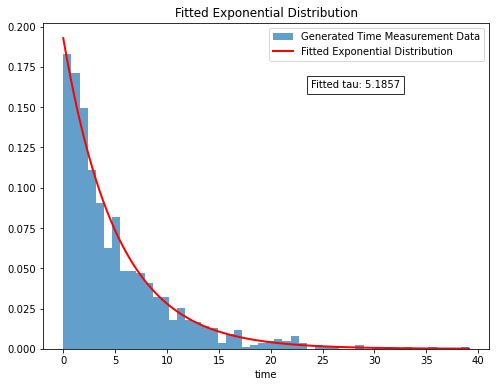

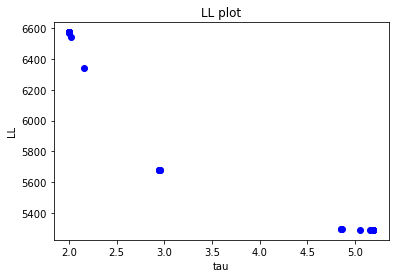

'\nbin_counts, bin_edges = returnHistBinCounts(outfile)\ntau_expected_binned = binned_fit_time_measurements(bin_counts, bin_edges)\nplot_time_measurement_fit(outfile, tau_expected_binned)\n\nbin_counts, bin_edges = returnHistBinCounts(outfile)\ntau_expected_binned_extended = extended_binned_fit_time_measurements(bin_counts, bin_edges)\nplot_time_measurement_fit(outfile, tau_expected_binned_extended)\n'

In [48]:
 # Fit distribution and then plot the fit along with data using unbinned likelihood
tau_expected = fit_time_measurements(outfile)
plot_time_measurement_fit(outfile, tau_expected)

# Plotting the likelihood
#print(tauArr)
#plt.plot(tauArr, llArr, marker='o', linestyle='-', color='b')
#plt.plot(tauArr, llArr, marker='o', color='b')
plt.scatter(tauArr, llArr, marker='o', color='b')

# Adding titles and labels
plt.title('LL plot')
plt.xlabel('tau')
plt.ylabel('LL')

# Showing the plot
plt.show()

# Fit distribution and then plot the fit along with data using binned likelihood
bin_counts, bin_edges = returnHistBinCounts(outfile)
tau_expected_binned = binned_fit_time_measurements(bin_counts, bin_edges)
plot_time_measurement_fit(outfile, tau_expected_binned)

# Fit distribution and then plot the fit along with data using extended binned likelihood
bin_counts, bin_edges = returnHistBinCounts(outfile)
tau_expected_binned_extended = extended_binned_fit_time_measurements(bin_counts, bin_edges)
plot_time_measurement_fit(outfile, tau_expected_binned_extended)


# Part 3: Do n2 such experiments and plot the fitted taus ; Please have a look at the mean of the gaussian (is it close to the tau value taken?)
The Central Limit Theorem:
For samples of size  30 or more, the sample mean is approximately normally distributed, with mean μ  and standard deviation = σ/√n; where σ = std of the sample=tau, n  is the sample size. 

Fitting the samples

Unbinned fit
Expected tau: 4.816653223063429 +/- 0.15227523516026498
Binned fit
Expected tau: 4.832308293675645 +/- 0.15461164968928287

Unbinned fit


/tmp/ipykernel_1427/1567906134.py:29: DeprecationWarning: Using factorial() with floats is deprecated
  lnL += -bincount_exp + count * math.log(bincount_exp) - math.log(math.factorial(count))


Expected tau: 4.801575267137711 +/- 0.15179867113632772
Binned fit
Expected tau: 4.808103352954483 +/- 0.1536893057101043

Unbinned fit
Expected tau: 5.208854557598688 +/- 0.1646691346665219
Binned fit
Expected tau: 5.535245074023318 +/- 0.2105441750631898

Unbinned fit
Expected tau: 5.163578768158497 +/- 0.16323821250561865
Binned fit
Expected tau: 5.159403374641943 +/- 0.16420734466501052

Unbinned fit
Expected tau: 4.975637031081021 +/- 0.15729955090688996
Binned fit
Expected tau: 4.980436494195858 +/- 0.15893443275185692

Unbinned fit
Expected tau: 4.964299457481292 +/- 0.1569410619611724
Binned fit
Expected tau: 4.99452860657813 +/- 0.16132109746258827

Unbinned fit
Expected tau: 4.879503935250945 +/- 0.1542613988839716
Binned fit
Expected tau: 4.885630183644924 +/- 0.15591443895457058

Unbinned fit
Expected tau: 4.95736104267231 +/- 0.15672133942064814
Binned fit
Expected tau: 5.070569544595028 +/- 0.1734817875194814

Unbinned fit
Expected tau: 5.11920652542984 +/- 0.161836042348

/tmp/ipykernel_1427/1186879443.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Unbinned fit
Expected tau: 5.093022550041377 +/- 0.1610086311034764
Binned fit
Expected tau: 5.096975694620076 +/- 0.16234846196569608

Unbinned fit
Expected tau: 4.616607037405844 +/- 0.145953070156434
Binned fit
Expected tau: 4.628534949125668 +/- 0.14979303077335793

Unbinned fit
Expected tau: 5.094717405015304 +/- 0.16106226511241317
Binned fit
Expected tau: 5.088473610482499 +/- 0.16149573521096983

Unbinned fit
Expected tau: 4.9078955264143564 +/- 0.15515861070245407
Binned fit
Expected tau: 4.922009590519492 +/- 0.1581754723630482

Unbinned fit
Expected tau: 5.19261175497005 +/- 0.16415546720702245
Binned fit
Expected tau: 5.275676111604382 +/- 0.17697690559149049

Unbinned fit
Expected tau: 4.8160071796461725 +/- 0.1522546027176248
Binned fit
Expected tau: 4.841526741213061 +/- 0.1571744366115313

Unbinned fit
Expected tau: 5.091045793089705 +/- 0.16094617833968883
Binned fit
Expected tau: 5.0785852315864615 +/- 0.16139899132131674

Unbinned fit
Expected tau: 5.127716117063428 

Expected tau: 5.052162644163605 +/- 0.15971776903097323
Binned fit
Expected tau: 5.182283755774935 +/- 0.17730393116103915

Unbinned fit
Expected tau: 4.67921803604056 +/- 0.14793180710822718
Binned fit
Expected tau: 4.686274648933944 +/- 0.14882777477926235

Unbinned fit
Expected tau: 4.812467451666181 +/- 0.15214293450437522
Binned fit
Expected tau: 4.917174405740096 +/- 0.16755804194783153

Unbinned fit
Expected tau: 4.917404983520003 +/- 0.1554592282984344
Binned fit
Expected tau: 5.031145072736348 +/- 0.171606837866924

Unbinned fit
Expected tau: 5.131602451601418 +/- 0.16222801320113778
Binned fit
Expected tau: 5.160055776612516 +/- 0.16610715206608884

Unbinned fit
Expected tau: 4.883146643110205 +/- 0.15437632121834843
Binned fit
Expected tau: 4.9033468833154705 +/- 0.15892243106576487

Unbinned fit
Expected tau: 4.9126805393909185 +/- 0.1553095674739211
Binned fit
Expected tau: 4.9153934774649946 +/- 0.15635166108932674

Unbinned fit
Expected tau: 5.361095276611033 +/- 0.16947

Expected tau: 4.913429157475184 +/- 0.1553334079014803
Binned fit
Expected tau: 4.926773944415064 +/- 0.156158956213456

Unbinned fit
Expected tau: 4.962469259891737 +/- 0.15688291686930267
Binned fit
Expected tau: 4.971537047865969 +/- 0.16160334740578275

Unbinned fit
Expected tau: 4.849420035587506 +/- 0.1533107416655195
Binned fit
Expected tau: 4.885141703458364 +/- 0.15985428171193883

Unbinned fit
Expected tau: 5.2208465335438206 +/- 0.16504735114517688
Binned fit
Expected tau: 5.34730542231277 +/- 0.18232695455419767

Unbinned fit
Expected tau: 4.986865372757653 +/- 0.15765405695276558
Binned fit
Expected tau: 4.982117132183171 +/- 0.16011054624155685

Unbinned fit
Expected tau: 5.386889457185362 +/- 0.17029469841282463
Binned fit
Expected tau: 5.395396660185719 +/- 0.17314929107646382

Unbinned fit
Expected tau: 5.180653726401318 +/- 0.16377762037468901
Binned fit
Expected tau: 5.19856570227682 +/- 0.16695159757271627

Unbinned fit
Expected tau: 4.993139015383422 +/- 0.15785256

Expected tau: 5.029753752974371 +/- 0.1706454432971931

Unbinned fit
Expected tau: 5.155712443559464 +/- 0.16298950854935068
Binned fit
Expected tau: 5.141127110006149 +/- 0.16368513459430867

Unbinned fit
Expected tau: 4.8675654941431095 +/- 0.15388430201977954
Binned fit
Expected tau: 4.878352099496655 +/- 0.1572421136935298

Unbinned fit
Expected tau: 5.026589841406254 +/- 0.15890939863406528
Binned fit
Expected tau: 5.081473644773496 +/- 0.16969101919388851

Unbinned fit
Expected tau: 5.078379112807221 +/- 0.16054593615049884
Binned fit
Expected tau: 5.099986181643781 +/- 0.1652490742897279

Unbinned fit
Expected tau: 4.817423274193588 +/- 0.15229979548246497
Binned fit
Expected tau: 4.836700903345696 +/- 0.15693955157968986

Unbinned fit
Expected tau: 4.85776966019993 +/- 0.15357446120435814
Binned fit
Expected tau: 4.872671666418034 +/- 0.15444039088721162

Unbinned fit
Expected tau: 5.153197674785707 +/- 0.16291010150266771
Binned fit
Expected tau: 5.208378634142979 +/- 0.170424

Expected tau: 5.147869035483411 +/- 0.16274136048386945
Binned fit
Expected tau: 5.356733590949888 +/- 0.19175260887770884

Unbinned fit
Expected tau: 4.855929644348203 +/- 0.1535166518476503
Binned fit
Expected tau: 4.872201103462717 +/- 0.1587252880798169

Unbinned fit
Expected tau: 4.769946464847258 +/- 0.1507993529205338
Binned fit
Expected tau: 4.775576934286029 +/- 0.1531798007802485

Unbinned fit
Expected tau: 4.918097654751636 +/- 0.15548108062076071
Binned fit
Expected tau: 5.031267960007085 +/- 0.1721037178029623

Unbinned fit
Expected tau: 5.149091268770404 +/- 0.162780407437642
Binned fit
Expected tau: 5.50838473623621 +/- 0.21223701905971515

Unbinned fit
Expected tau: 4.989876958363052 +/- 0.1577492981662414
Binned fit
Expected tau: 5.048197289272076 +/- 0.16772546855663206

Unbinned fit
Expected tau: 5.1946901522399855 +/- 0.1642206332276399
Binned fit
Expected tau: 5.226097652515529 +/- 0.1703783538715684

Unbinned fit
Expected tau: 4.905581728289653 +/- 0.1550852864273

Expected tau: 4.958120635067537 +/- 0.15674540962056538
Binned fit
Expected tau: 4.981380020374553 +/- 0.16087820923680374

Unbinned fit
Expected tau: 5.2177203154025245 +/- 0.16494848808375195
Binned fit
Expected tau: 5.2193876083997734 +/- 0.16569593541712457

Unbinned fit
Expected tau: 4.951597351329145 +/- 0.15653940998130578
Binned fit
Expected tau: 4.947910230541066 +/- 0.15823244027071226

Unbinned fit
Expected tau: 5.098394741828714 +/- 0.16117850119979105
Binned fit
Expected tau: 5.218232375367574 +/- 0.17814140981559623

Unbinned fit
Expected tau: 4.827100227610354 +/- 0.1526055737999874
Binned fit
Expected tau: 4.929367066363284 +/- 0.16702310589544478

Unbinned fit
Expected tau: 4.84777414869157 +/- 0.15325843692893715
Binned fit
Expected tau: 4.93927493639594 +/- 0.16852299870045906

Unbinned fit
Expected tau: 5.116498611510982 +/- 0.1617508522234301
Binned fit
Expected tau: 5.1791688828371605 +/- 0.17192100513911823

Unbinned fit
Expected tau: 5.0398790246048835 +/- 0.159

Expected tau: 4.736674593182605 +/- 0.1497476790247827
Binned fit
Expected tau: 4.707330442564037 +/- 0.14950812597751728

Unbinned fit
Expected tau: 4.93474338090303 +/- 0.15600700414758073
Binned fit
Expected tau: 4.921629508324859 +/- 0.15595553062240164

Unbinned fit
Expected tau: 5.023692943690964 +/- 0.15881836949058137
Binned fit
Expected tau: 5.152941659335273 +/- 0.1796921972892105

Unbinned fit
Expected tau: 5.048789738110323 +/- 0.15961090521352972
Binned fit
Expected tau: 5.038308669551065 +/- 0.16006217749334217

Unbinned fit
Expected tau: 4.782718387284124 +/- 0.1512027539880445
Binned fit
Expected tau: 4.81725180576067 +/- 0.15880559504827385

Unbinned fit
Expected tau: 4.814784003845893 +/- 0.1522160144978839
Binned fit
Expected tau: 4.807953175216091 +/- 0.15310578421965326

Unbinned fit
Expected tau: 4.830510560294685 +/- 0.15271336571924898
Binned fit
Expected tau: 4.920493822057184 +/- 0.1675044103488883

Unbinned fit
Expected tau: 5.357632391775934 +/- 0.1693687918

Unbinned fit
Expected tau: 5.196880352621764 +/- 0.16429038479064229
Binned fit
Expected tau: 5.204828367993513 +/- 0.16688260413934186

Unbinned fit
Expected tau: 4.927097894563423 +/- 0.15576542503567214
Binned fit
Expected tau: 5.015540007421945 +/- 0.16913306081055213

Unbinned fit
Expected tau: 4.849129516433018 +/- 0.15330126863649962
Binned fit
Expected tau: 4.847814177113069 +/- 0.15510127985110955

Unbinned fit
Expected tau: 5.058849897339189 +/- 0.15992929733166994
Binned fit
Expected tau: 5.094073032878114 +/- 0.16569507438620112

Unbinned fit
Expected tau: 4.93708338504984 +/- 0.15608094297824948
Binned fit
Expected tau: 4.940391992984495 +/- 0.1582525317645831

Unbinned fit
Expected tau: 5.180218883182903 +/- 0.16376361311662668
Binned fit
Expected tau: 5.242784350618779 +/- 0.17671716339067078

Unbinned fit
Expected tau: 5.095826464431706 +/- 0.16109717135284995
Binned fit
Expected tau: 5.211591722875858 +/- 0.17786431306300088

Unbinned fit
Expected tau: 4.83771144807344

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f121239ef70> (for post_execute):


KeyboardInterrupt: 

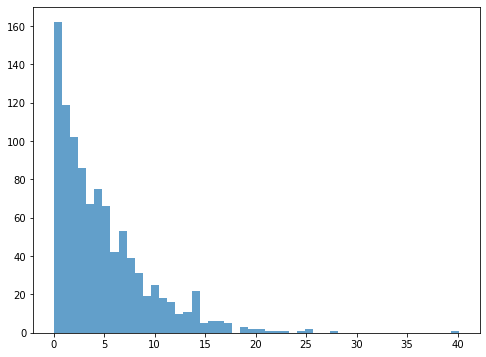

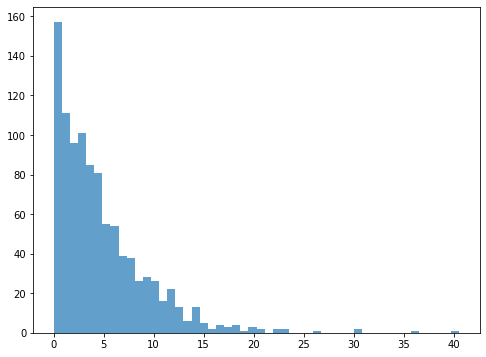

Error in callback <function flush_figures at 0x7f116c6535e0> (for post_execute):


KeyboardInterrupt: 

In [63]:
n2=1000 #total number of experiments
tau_expected_samples = []
tau_expected_samples_binned = []
print("Fitting the samples")
for _ in range(n2):
    print("")
    time_measurements_sample = np.array(generate_time(n1,tau))
    #time_measurements_samples = np.array(generate_time_numpy(n1,tau))# to use numpy                                                                                                                       
    outfileTemp = ROOT.TFile("DecayTimeMeasurementsSample.root", "recreate")
    ### unbinned fit
    print("Unbinned fit")
    fill_tree_with_time(outfileTemp, time_measurements_sample)
    tau_expected_sample  = fit_time_measurements(outfileTemp)
    tau_expected_samples.append(tau_expected_sample)
    
    ###binned fit
    print("Binned fit")
    bin_counts, bin_edges = returnHistBinCounts(outfileTemp)
    tau_expected_sample_binned = binned_fit_time_measurements(bin_counts, bin_edges)
    tau_expected_samples_binned.append(tau_expected_sample_binned)


In [ ]:
def plot_tau_expected(tau_expected_samples):
    plt.figure(figsize=(12, 6))
    plt.hist(tau_expected_samples, bins=25, density=True, alpha=0.7, label="tau expected")
    plt.xlabel("tau expected")
    plt.ylabel(" ")
    plt.title("Histogram of expected tau in many experiments")
    plt.legend()
    plt.show()

In [ ]:
plot_tau_expected(tau_expected_samples) ### plot the expected tau for unbinned fit
plot_tau_expected(tau_expected_samples_binned) ### plot the expected tau for binned fit

# Part 4: From the distribution of expected tau, calculate the std and match with the expected (σ/√n1) one from CLT

In [ ]:
def check_error(tau_expected_samples,n1,n2,tau):
    #sample_mean_std1 = np.std(samples_mean)
    sum_squared_diff = np.sum((tau_expected_samples - np.mean(tau_expected_samples))**2)
    tau_expected_std = np.sqrt(sum_squared_diff/(n2-1))
    time_measurements_std = tau/(np.sqrt(n1))
    print(f"Error on the tau expected: {tau_expected_std:.4f}")
    print(f"Expected std : {time_measurements_std:.4f}")
    print(f"Ratio: {tau_expected_std / time_measurements_std:.4f}")

In [18]:
check_error(tau_expected_samples, n1, n2, tau)

Error on the tau expected: 0.1577
Expected std : 0.1581
Ratio: 0.9974
